# SARIMAX 

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## United States Macroeconomic Dataset 

In [3]:
macro_data = sm.datasets.macrodata.load_pandas()

In [4]:
macro_data.data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [5]:
macro_data = macro_data.data

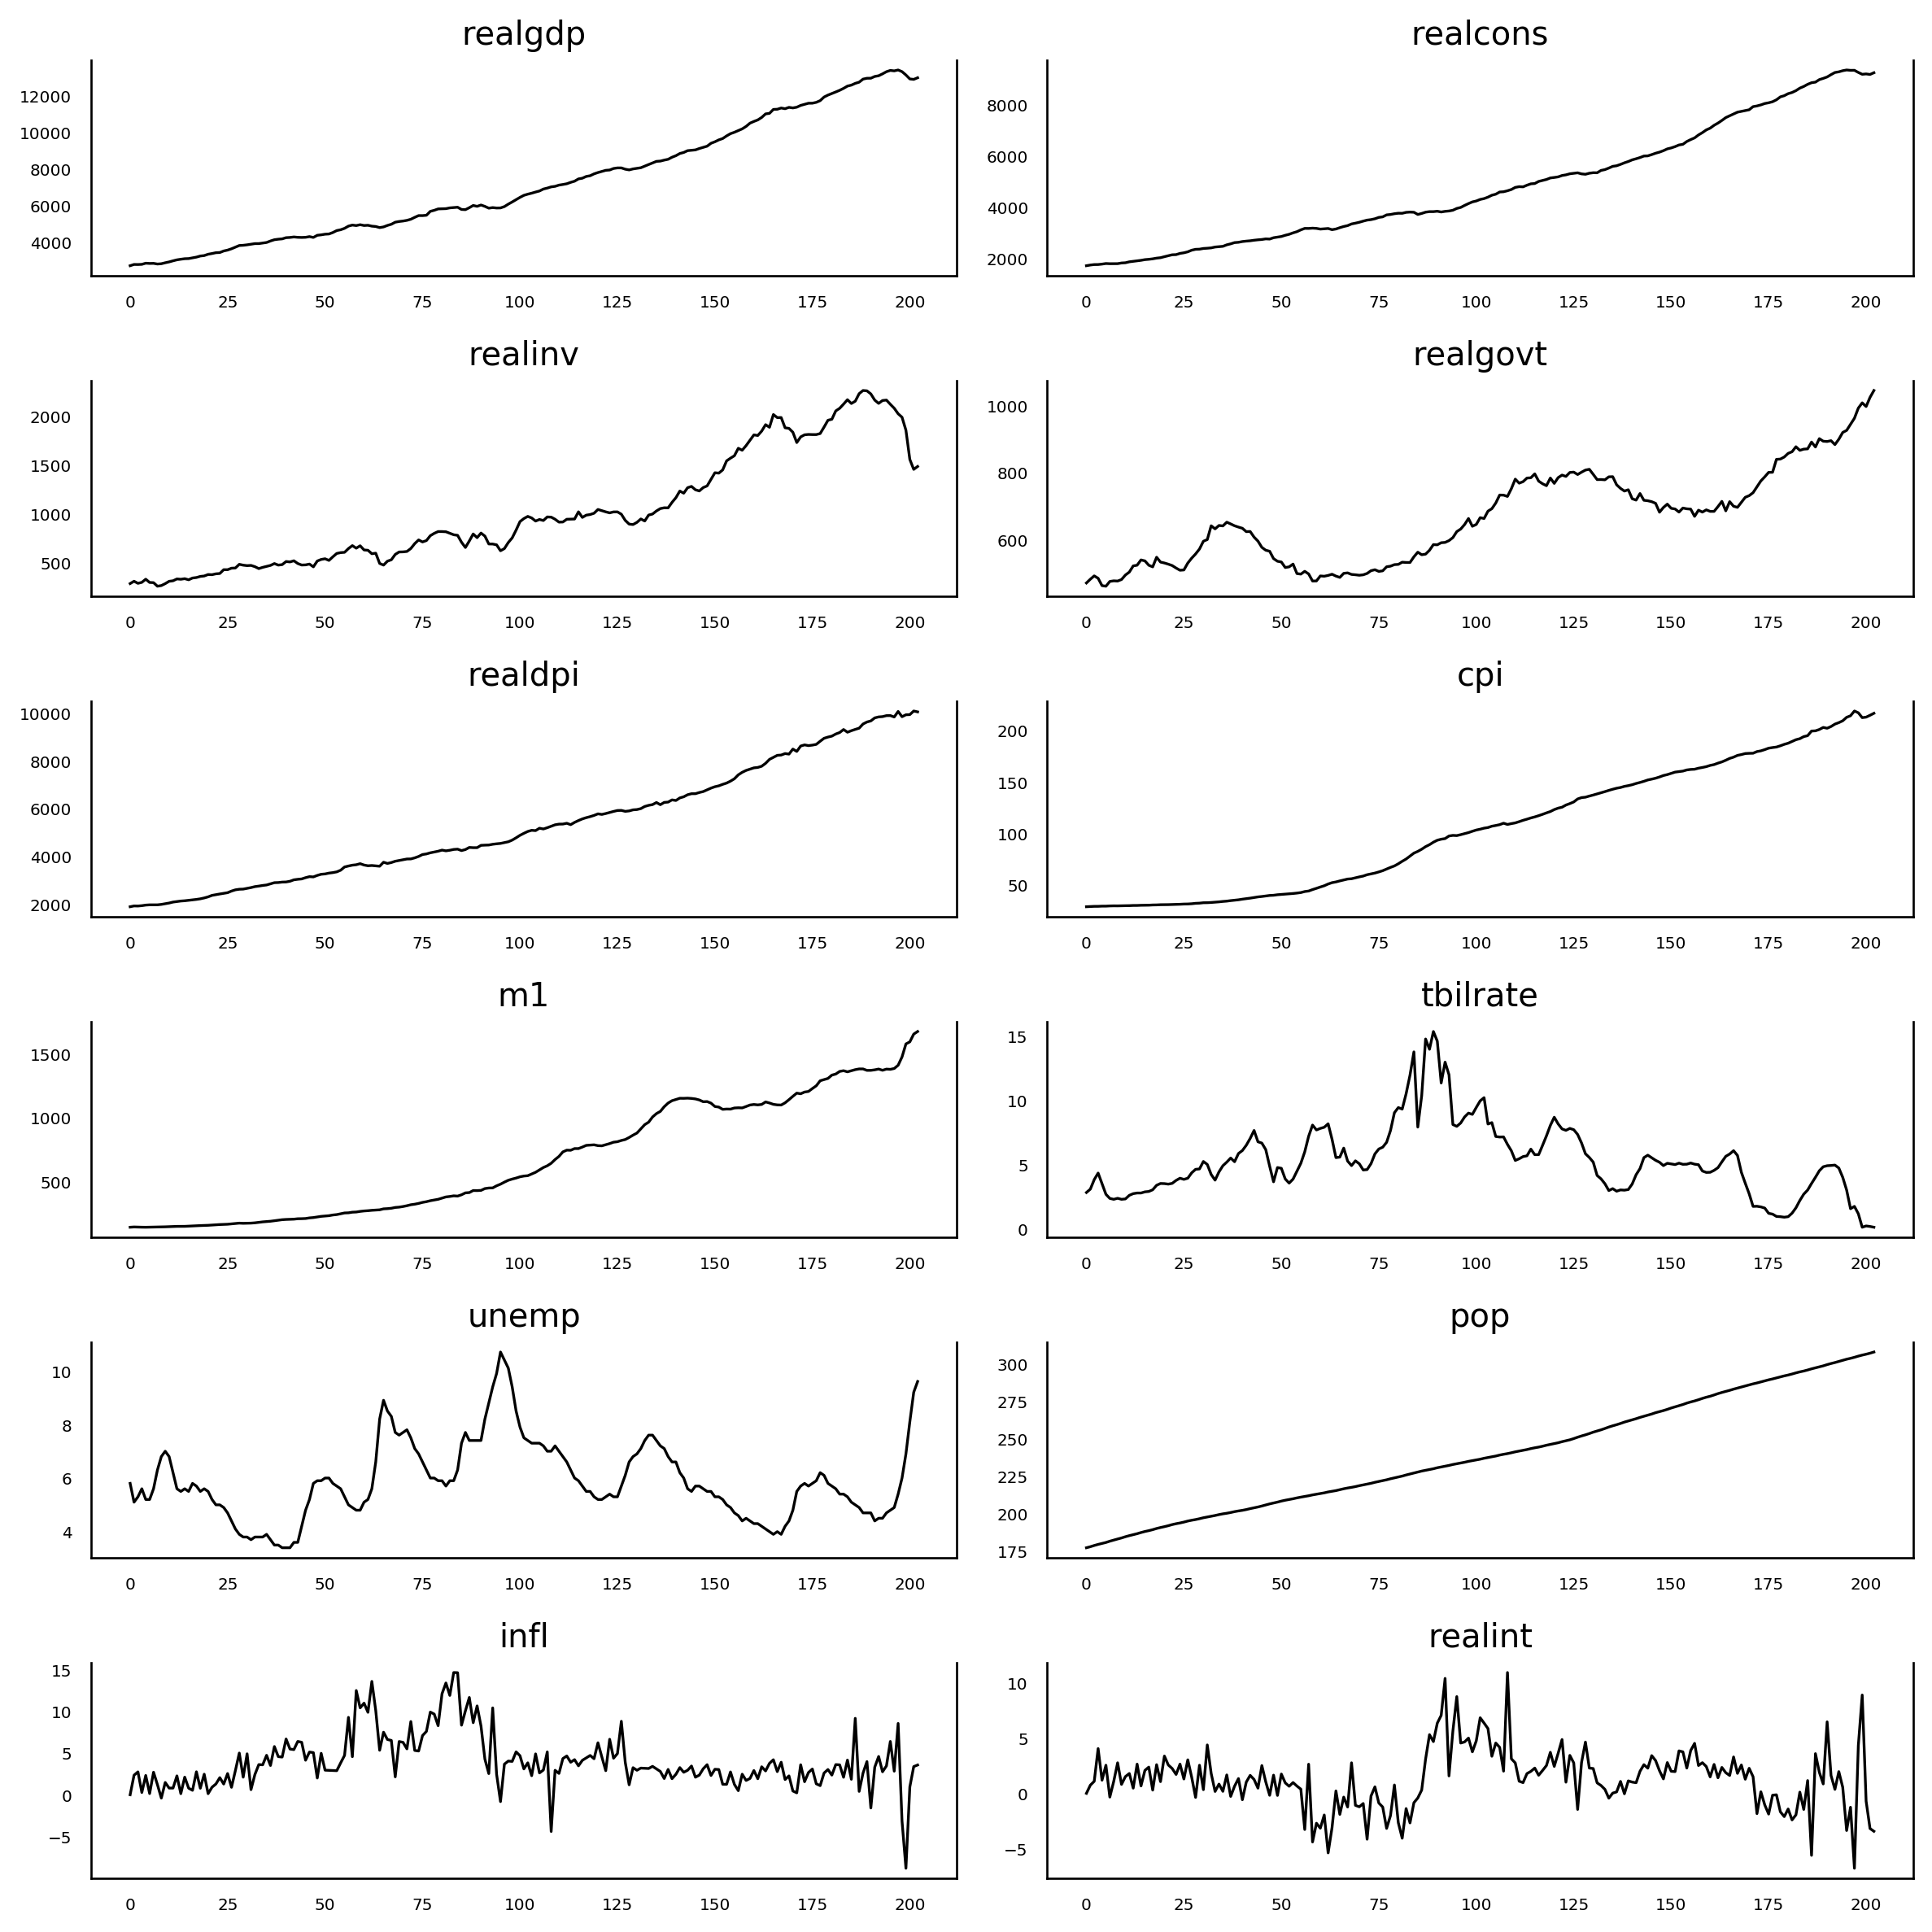

In [6]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=240, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

In [7]:
macro_data['realgdp_tr1'] = macro_data['realgdp'].diff()

macro_data.head(10)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realgdp_tr1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,68.452
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,-3.313
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,9.716
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,62.495
5,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55,-13.309
6,1960.0,3.0,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34,4.632
7,1960.0,4.0,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08,-36.406
8,1961.0,1.0,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77,16.648
9,1961.0,2.0,2872.005,1814.3,286.246,480.328,2014.4,29.92,142.9,2.29,7.0,183.691,1.47,0.81,52.741


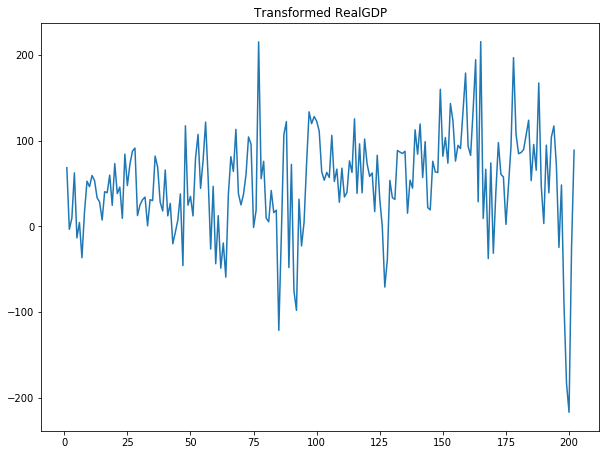

In [8]:
plt.plot(macro_data['realgdp_tr1'])
plt.title('Transformed RealGDP')
plt.show()

In [9]:
ad_fuller_result = adfuller(macro_data['realgdp_tr1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


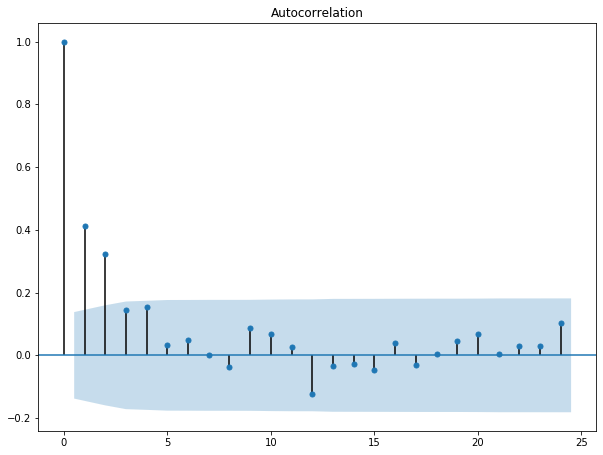

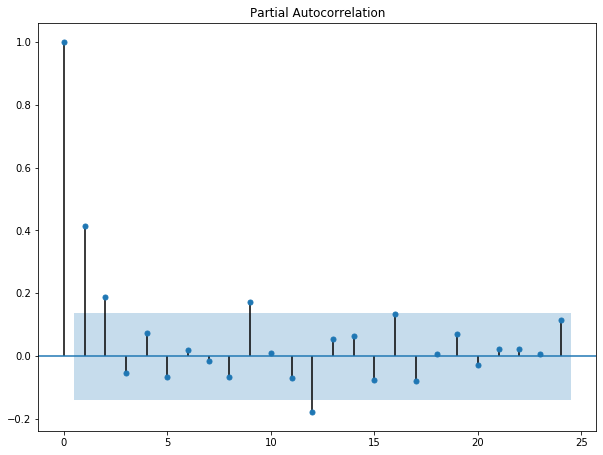

In [10]:
plot_acf(macro_data['realgdp_tr1'][1:]);
plot_pacf(macro_data['realgdp_tr1'][1:]);

In [11]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):
    """
        Returns dataframe with parameters, corresponding AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list with (p, d, P, Q)tuples
        d - integration order
        D - seasonal integration order
        s - length of the season
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,
                           exog,
                           order=(param[0], d, param[1]),
                           seasonal_order=(param[2], D, param[3], s),
                           simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [13]:
endog = macro_data['realgdp'][:200]
exog = macro_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']][:200]

result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 4)
result_df

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 1, 0)",1757.191898
1,"(3, 3, 0, 0)",1757.896503
2,"(2, 2, 0, 2)",1758.331775
3,"(2, 2, 0, 0)",1759.091696
4,"(2, 2, 2, 0)",1759.846491
...,...,...
251,"(3, 2, 2, 1)",1776.806703
252,"(3, 2, 1, 3)",1776.867134
253,"(3, 2, 1, 1)",1776.944883
254,"(3, 2, 1, 2)",1778.132090


In [15]:
best_model = SARIMAX(endog, 
                     exog, 
                     order=(2,1,2), 
                     seasonal_order=(1,0,0,4),
                    simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -861.596
Date:                            Wed, 17 Feb 2021   AIC                           1757.192
Time:                                    16:11:13   BIC                           1813.178
Sample:                                         0   HQIC                          1779.851
                                            - 200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9565      0.053     17.927      0.000       0.852       1.061
realinv        1.0007      0.042   

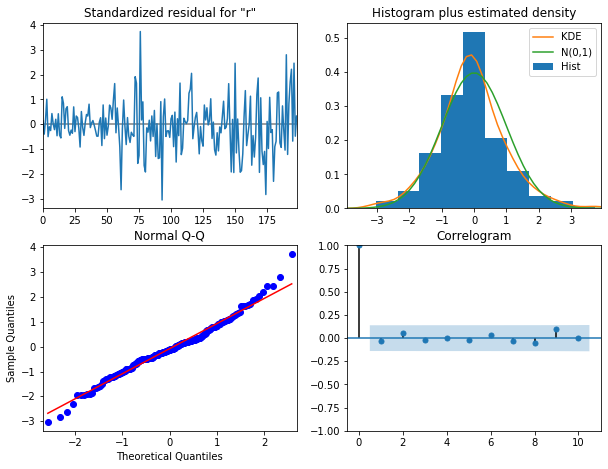

In [16]:
res.plot_diagnostics();

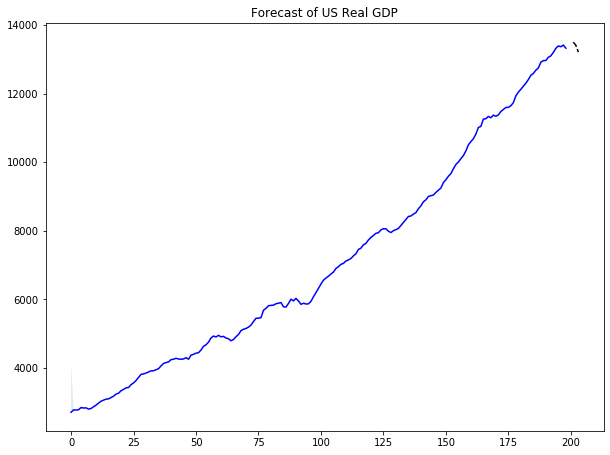

In [17]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                            exog = exog.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'][:199], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)

ax.set_title('Forecast of US Real GDP')
plt.show()

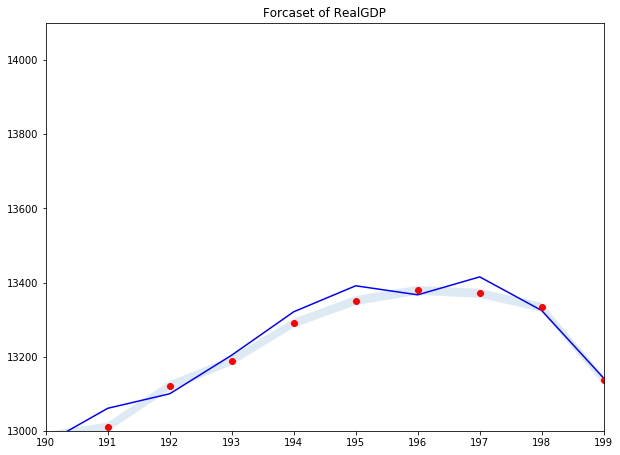

In [18]:
fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.plot(predict.predicted_mean, 'ro')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)
ax.set_xlim(190,199)
ax.set_ylim(13000, 14100)

ax.set_title('Forcaset of RealGDP')
plt.show()

In [21]:
mse = mean_squared_error(macro_data['realgdp'], predict.predicted_mean[:203])

print(f'MSE: {mse}')

MSE: 7059.697709444256


In [22]:
mape = np.mean(np.abs(macro_data['realgdp'] - predict.predicted_mean[:203]) / np.abs(macro_data['realgdp']))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: 0.39%
